# Classifying data

## Pick and pre-process data

For the preprocessing of the data from raw mulivariable net cdf files to usable design matrices and targets we need:

In [2]:
from src.preproces import Handle_Files
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

file_handler = Handle_Files()

seed = 502
np.random.seed(seed)

We will use only files from ssp126 and ssp585 scenarios. For each ssp we have 40 realisations and we will take $(2*40).8=64$ files by random for training and $16$ for testing.

In [3]:
target_mapping = {'ssp126': 0, 'ssp585': 1}
rev_target_mapping = {v: k for k, v in target_mapping.items()}

In [4]:
def extract_cross_sections(data_dir, ssp_names, center_year, target_mapping, pm=1):
    
    start_year = center_year - pm
    end_year = center_year + pm  

    df = pd.DataFrame(columns=['pr', 'tas', 'target_ssp'], 
                      index=np.arange(len(ssp_names)*40))
    indx = 0

    for ssp_name in ssp_names:
        ssp_dir = os.path.join(data_dir, ssp_name)
        file_list = os.listdir(ssp_dir)

        for file_name in file_list:
            file_path = os.path.join(ssp_dir, file_name)
            ds = xr.open_dataset(file_path)
            
            ds_years = ds.sel(year=slice(start_year, end_year))
            mean_pr = ds_years.pr.mean(dim='year').values
            mean_tas = ds_years.tas.mean(dim='year').values

            df.loc[indx] = [mean_pr, mean_tas, target_mapping[ssp_name]] 
            
            indx += 1         
    
    return df

In [5]:
def plot_split(df_train, train_target, title, df_test=None, test_target=None):
    
    fig, ax = plt.subplots()

    if df_test is None:
        scatter_plot = ax.scatter(df_train['tas'], df_train['pr'], 
                                  marker='o', c=train_target, 
                                  cmap='coolwarm')
    else:
        ax.scatter(df_train['tas'], df_train['pr'], 
                   marker='o', c=train_target, 
                   cmap='coolwarm')
        scatter_plot = ax.scatter(df_test['tas'], df_test['pr'],
                                  marker='x', c=test_target, 
                                  cmap='coolwarm', label='Test data')


    colors = [handle.get_color() for handle in scatter_plot.legend_elements(prop='colors')[0]]

    handles = [mlines.Line2D([], [], color=colors[1], marker='o', markersize=8, label='Train data ssp126', linestyle='None'), 
               mlines.Line2D([], [], color=colors[0], marker='o', markersize=8, label='Train data ssp585', linestyle='None')]
    
    if df_test is not None:
        handles.append(mlines.Line2D([], [], color=colors[1], marker='x', markersize=8, label='Test data ssp126', linestyle='None'))
        handles.append(mlines.Line2D([], [], color=colors[0], marker='x', markersize=8, label='Test data ssp585', linestyle='None'))
    

    ax.set_xlabel('tas')
    ax.set_ylabel('pr')

    plt.title(title)
    plt.legend(handles=handles)
    plt.show()

In [6]:
data_dir = '/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/multivariate'
ssp_names = ['ssp126', 'ssp585']

df_15_17 = extract_cross_sections(data_dir, ssp_names, 2016, target_mapping)
df_18_20 = extract_cross_sections(data_dir, ssp_names, 2019, target_mapping)
df_21_23 = extract_cross_sections(data_dir, ssp_names, 2022, target_mapping)
df_24_26 = extract_cross_sections(data_dir, ssp_names, 2025, target_mapping)
df_27_29 = extract_cross_sections(data_dir, ssp_names, 2028, target_mapping)
df_30_32 = extract_cross_sections(data_dir, ssp_names, 2031, target_mapping)
df_33_35 = extract_cross_sections(data_dir, ssp_names, 2034, target_mapping)
df_36_38 = extract_cross_sections(data_dir, ssp_names, 2037, target_mapping)
df_39_41 = extract_cross_sections(data_dir, ssp_names, 2040, target_mapping)

               pr        tas target_ssp
0   3.1410676e-05   280.1274          0
1    3.144682e-05  280.23746          0
2   3.1421692e-05   280.0614          0
3   3.1477528e-05   280.3718          0
4    3.144682e-05  280.16272          0
..            ...        ...        ...
75  3.1586136e-05  280.50696          1
76  3.1473464e-05  280.42456          1
77  3.1545977e-05  280.67087          1
78  3.1476695e-05  280.43527          1
79   3.150021e-05  280.66635          1

[80 rows x 3 columns]


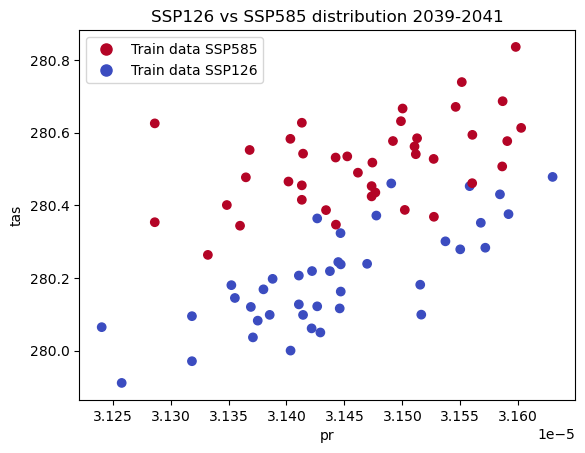

In [7]:
print(df_39_41)
fig, ax = plt.subplots()


scatter_plot = ax.scatter(df_39_41['pr'], df_39_41['tas'],
                          marker='o', c=df_39_41['target_ssp'], 
                          cmap='coolwarm')

colors = [handle.get_color() for handle in scatter_plot.legend_elements(prop='colors')[0]]

handles = [mlines.Line2D([], [], color=colors[1], marker='o', markersize=8, label='Train data SSP585', linestyle='None'), 
            mlines.Line2D([], [], color=colors[0], marker='o', markersize=8, label='Train data SSP126', linestyle='None')]

ax.set_xlabel('pr')
ax.set_ylabel('tas')

plt.title('SSP126 vs SSP585 distribution 2039-2041')
plt.legend(handles=handles)
plt.show()

we now have a usable format. I will performe a test-train split. One key thing to note is that this data are on totally different scale with tas being on order of $10^2$ while pr i on scale $10^{-5}$. We will need to scale the data. 

In [8]:
import warnings
warnings.filterwarnings('ignore')

dataframes_dict = {'df_15_17': df_15_17, 
                   'df_18_20': df_18_20, 
                   'df_21_23': df_21_23, 
                   'df_24_26': df_24_26, 
                   'df_27_29': df_27_29, 
                   'df_30_32': df_30_32, 
                   'df_33_35': df_33_35, 
                   'df_36_38': df_36_38, 
                   'df_39_41': df_39_41}
scaler = StandardScaler()

for name, df in dataframes_dict.items():
    # Extract suffix from name for dynamic variable naming
    suffix = re.findall(r"(_\d+_\d+)", name)[0]
    # Create a new variable based on the DataFrame with split data
    exec(f"X_train{suffix}, X_test{suffix}, y_train{suffix}, y_test{suffix}  = train_test_split(df[['tas', 'pr']], df['target_ssp'], test_size=0.2, random_state=seed)")
    
    # Standard scale X_train{suffix} and X_test{suffix}
    exec(f"X_train_scaled{suffix} = scaler.fit_transform(X_train{suffix})")
    exec(f"X_test_scaled{suffix} = scaler.fit_transform(X_test{suffix})")
    exec(f"y_train{suffix} = y_train{suffix}.to_numpy().astype(int)")
    exec(f"y_test{suffix} = y_test{suffix}.to_numpy().astype(int)")

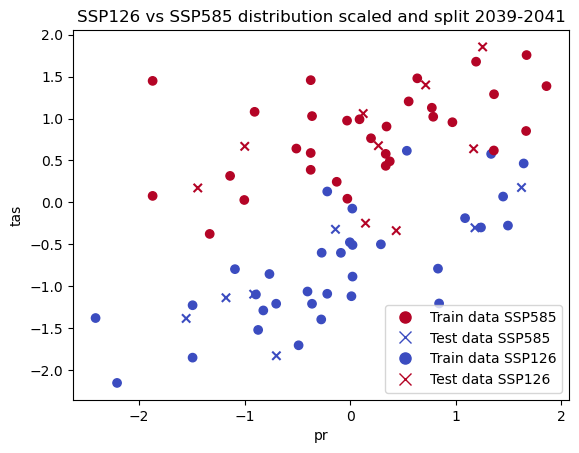

In [9]:
fig, ax = plt.subplots()
ax.scatter(X_train_scaled_39_41[:, 1], X_train_scaled_39_41[:, 0], marker='o', c=y_train_39_41, cmap='coolwarm')

scatter_plot = ax.scatter(X_test_scaled_39_41[:, 1], X_test_scaled_39_41[:, 0], marker='x', c=y_test_39_41, cmap='coolwarm')

colors = [handle.get_color() for handle in scatter_plot.legend_elements(prop='colors')[0]]

handles = [mlines.Line2D([], [], color=colors[1], marker='o', markersize=8, label='Train data SSP585', linestyle='None'), 
           mlines.Line2D([], [], color=colors[0], marker='x', markersize=8, label='Test data SSP585', linestyle='None'),
           mlines.Line2D([], [], color=colors[0], marker='o', markersize=8, label='Train data SSP126', linestyle='None'),
           mlines.Line2D([], [], color=colors[1], marker='x', markersize=8, label='Test data SSP126', linestyle='None')]
    
ax.set_xlabel('pr')
ax.set_ylabel('tas')
plt.title('SSP126 vs SSP585 distribution scaled and split 2039-2041')
plt.legend(handles=handles)
plt.show()

# SVM

For our classification I will start with the latest period 39-41 since this will be among the easiest to classify. As we move towards the earlier periods, I do not think I will be able to make classifications. 

The SVM classification concerns with:
- model tuning, herunder I will tune
    - the slack cost $C$. How many support vectors does the model allow for 
    - The kernel of the model 
    - The gamma parameter 

Let us start with importing the new libraries needed before defining a parameter grid and performing a grid search with cross validation.

Import new libraries

In [10]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

A function that displays some key information

In [11]:

def plot_cm(y_test, y_pred, cm_title, best_parameters):
    
    fig, ax = plt.subplots()
    
    f1_score = sklearn.metrics.f1_score(y_test, y_pred)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(vmin=0, vmax=14)
    sns.heatmap(cm, ax=ax, cmap=cmap, norm=norm, annot=True, fmt='d')

    ax.set_xticklabels([rev_target_mapping[tick] for tick in [0, 1]])
    ax.set_yticklabels([rev_target_mapping[tick] for tick in [0, 1]])

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(cm_title)


    plt.text(1, 2.4, 
            f'F1 Score: {f1_score:.2f},      Accuracy: {accuracy:.2f}', 
            fontsize=12, ha='center')
    plt.text(1, 2.6,
            f'Best parameters: {best_parameters}',
            fontsize=12, ha='center')
    
    plt.show()

define hyperparameter grid and set up grid search object.

In [22]:
np.logspace(-4, 0, 5)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [12]:
hyper_grid_SVC = {'C': np.logspace(-3, 2, 6),
                  'gamma': np.logspace(-4, 0, 5),
                  'kernel': ['rbf', 'linear', 'sigmoid'],
                  'degree': [2, 6, 10]}


SVC_clf = GridSearchCV(SVC(), hyper_grid_SVC, 
                       scoring='accuracy',
                       cv=3,
                       refit=True, 
                       return_train_score=True)

Now, let us work through each time segment I will do it in reverse to observe when the "signal" becomes to noisy.

In [13]:
d = {'2039-2041': [X_train_scaled_39_41, y_train_39_41, X_test_scaled_39_41, y_test_39_41],
     '2036-2038': [X_train_scaled_36_38, y_train_36_38, X_test_scaled_36_38, y_test_36_38],
     '2033-2035': [X_train_scaled_33_35, y_train_33_35, X_test_scaled_33_35, y_test_33_35],
     '2030-2032': [X_train_scaled_30_32, y_train_30_32, X_test_scaled_30_32, y_test_30_32],
     '2027-2029': [X_train_scaled_27_29, y_train_27_29, X_test_scaled_27_29, y_test_27_29],
     '2024-2026': [X_train_scaled_24_26, y_train_24_26, X_test_scaled_24_26, y_test_24_26],
     '2021-2023': [X_train_scaled_21_23, y_train_21_23, X_test_scaled_21_23, y_test_21_23],
     '2018-2020': [X_train_scaled_18_20, y_train_18_20, X_test_scaled_18_20, y_test_18_20],
     '2015-2017': [X_train_scaled_15_17, y_train_15_17, X_test_scaled_15_17, y_test_15_17]}

In [14]:
f1_scores_svc = pd.DataFrame(columns=['Period', 'F1 score_train', 'F1 score_test', 'Model'],
                             index=np.arange(len(d)))


for indx, (period, data) in enumerate(d.items()):

    SVC_clf.fit(data[0], data[1])

    best_model = SVC_clf.best_estimator_
    best_parameters = SVC_clf.best_params_
    best_f1_train = SVC_clf.best_score_

    y_pred = best_model.predict(data[2])
    f1_test = sklearn.metrics.accuracy_score(data[3], y_pred)

    f1_scores_svc.loc[indx] = [period, best_f1_train, f1_test, best_parameters]
    #plot_cm(data[3], y_pred, f'Confusion matrix SVC {period}', best_parameters)

print(f1_scores_svc)

      Period F1 score_train F1 score_test  \
0  2039-2041       0.953102         0.875   
1  2036-2038       0.953102           1.0   
2  2033-2035       0.873737        0.9375   
3  2030-2032       0.841991          0.75   
4  2027-2029       0.828283        0.6875   
5  2024-2026       0.704185         0.625   
6  2021-2023       0.640693           0.5   
7  2018-2020       0.532468        0.4375   
8  2015-2017       0.548341           0.5   

                                               Model  
0  {'C': 1.0, 'degree': 2, 'gamma': 0.0001, 'kern...  
1  {'C': 100.0, 'degree': 2, 'gamma': 0.01, 'kern...  
2  {'C': 10.0, 'degree': 2, 'gamma': 0.0001, 'ker...  
3  {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel'...  
4  {'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel...  
5  {'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel...  
6  {'C': 100.0, 'degree': 2, 'gamma': 1.0, 'kerne...  
7  {'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel'...  
8  {'C': 10.0, 'degree': 2, 'gamma': 0.0001, 'ker...  

# Tree based methods

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

## Descision trees

Hyperparameters 
- Max depth
- min_impurity_decrease

In [16]:
hyper_grid_DT = {'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 50],
                 'min_samples_leaf': [2, 4, 6]}


DT_clf = GridSearchCV(DecisionTreeClassifier(), hyper_grid_DT, 
                      scoring='f1',
                      cv=3,
                      refit=True, 
                      return_train_score=True)

Now that the grid is set up we can iterate through periods as we did for SVC

In [17]:
f1_scores_DT = pd.DataFrame(columns=['Period', 'F1 score_train', 'F1 score_test', 'Model'],
                             index=np.arange(len(d)))


for indx, (period, data) in enumerate(d.items()):

    DT_clf.fit(data[0], data[1])

    best_model = DT_clf.best_estimator_
    best_parameters = DT_clf.best_params_
    best_f1_train = DT_clf.best_score_

    y_pred = best_model.predict(data[2])
    f1_test = sklearn.metrics.f1_score(data[3], y_pred)

    f1_scores_DT.loc[indx] = [period, best_f1_train, f1_test, best_parameters]
    #plot_cm(data[3], y_pred, f'Confusion matrix DT {period}', best_parameters)

print(f1_scores_DT)

      Period F1 score_train F1 score_test  \
0  2039-2041       0.895916      0.823529   
1  2036-2038       0.860661      0.823529   
2  2033-2035       0.846377         0.875   
3  2030-2032       0.766934      0.666667   
4  2027-2029       0.665121      0.666667   
5  2024-2026        0.56526         0.625   
6  2021-2023       0.568984      0.470588   
7  2018-2020       0.508485           0.6   
8  2015-2017       0.556348           0.4   

                                      Model  
0   {'max_depth': 1, 'min_samples_leaf': 2}  
1   {'max_depth': 2, 'min_samples_leaf': 4}  
2   {'max_depth': 3, 'min_samples_leaf': 4}  
3   {'max_depth': 3, 'min_samples_leaf': 4}  
4   {'max_depth': 3, 'min_samples_leaf': 4}  
5   {'max_depth': 5, 'min_samples_leaf': 2}  
6   {'max_depth': 1, 'min_samples_leaf': 6}  
7  {'max_depth': 10, 'min_samples_leaf': 2}  
8   {'max_depth': 5, 'min_samples_leaf': 2}  


## Random forest

Hyperparameters considered
- Should we use bagging?
- The number of threes
- maximum three depth
- minimum information gain

In [18]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [19]:
hyper_grid_RF = {'n_estimators': [10, 50, 100, 500, 1000, 10000]}


RF_clf = GridSearchCV(RandomForestClassifier(random_state=seed, max_features='sqrt', bootstrap=True), 
                      hyper_grid_RF, 
                      scoring='f1',
                      cv=3,
                      refit=True, 
                      return_train_score=True)

In [20]:
f1_scores_RF = pd.DataFrame(columns=['Period', 'F1 score_train', 'F1 score_test', 'Model'],
                             index=np.arange(len(d)))


for indx, (period, data) in enumerate(d.items()):

    RF_clf.fit(data[0], data[1])

    best_model = RF_clf.best_estimator_
    best_parameters = RF_clf.best_params_
    best_f1_train = RF_clf.best_score_

    y_pred = best_model.predict(data[2])
    f1_test = sklearn.metrics.f1_score(data[3], y_pred)

    f1_scores_RF.loc[indx] = [period, best_f1_train, f1_test, best_parameters]
    #plot_cm(data[3], y_pred, f'Confusion matrix DT {period}', best_parameters)

print(f1_scores_RF)

      Period F1 score_train F1 score_test                    Model
0  2039-2041       0.910346         0.875   {'n_estimators': 1000}
1  2036-2038       0.877684      0.947368     {'n_estimators': 50}
2  2033-2035       0.838095      0.941176     {'n_estimators': 10}
3  2030-2032        0.72619      0.842105  {'n_estimators': 10000}
4  2027-2029       0.711111      0.666667   {'n_estimators': 1000}
5  2024-2026       0.660725      0.470588     {'n_estimators': 50}
6  2021-2023        0.52729           0.5    {'n_estimators': 500}
7  2018-2020       0.456296         0.375  {'n_estimators': 10000}
8  2015-2017       0.475045      0.526316    {'n_estimators': 500}


## Adaboost classification

In [69]:
hyper_grid_DT = {'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 50],
                 'min_samples_split': [1, 2, 5, 10],
                 'min_samples_leaf': [2, 4, 6]}

DT_clf = GridSearchCV(DecisionTreeClassifier(), hyper_grid_DT, 
                      scoring='f1',
                      cv=3,
                      refit=True, 
                      return_train_score=True)

hyper_grid_ada = {'n_estimators': [10, 50, 100, 200, 500, 1000]}

In [70]:
f1_scores_ada = pd.DataFrame(columns=['Period', 'F1 score_train', 'F1 score_test', 'Model'],
                             index=np.arange(len(d)))


for indx, (period, data) in enumerate(d.items()):

    DT_clf.fit(data[0], data[1])

    best_DT_model = DT_clf.best_estimator_
    best_DT_parameters = DT_clf.best_params_
    
    ada_clf = GridSearchCV(AdaBoostClassifier(best_DT_model),
                           hyper_grid_ada,
                           scoring='f1',
                           cv=3,
                           refit=True, 
                           return_train_score=True)    

    ada_clf.fit(data[0], data[1])

    best_model = ada_clf.best_estimator_
    best_parameters = ada_clf.best_params_
    best_f1_train = ada_clf.best_score_

    y_pred = best_model.predict(data[2])
    f1_test = sklearn.metrics.f1_score(data[3], y_pred)

    f1_scores_ada.loc[indx] = [period, best_f1_train, f1_test, {**best_DT_parameters, **best_parameters}]
    #plot_cm(data[3], y_pred, f'Confusion matrix DT {period}', best_parameters)

display(f1_scores_ada)


KeyboardInterrupt: 

# Classifier compairison

In [71]:
f1_scores_svc['classifier'] = 'SVC'
f1_scores_DT['classifier'] = 'DT'
f1_scores_RF['classifier'] = 'RF'
#f1_scores_ada['classifier'] = 'ADA'

f1_scores = pd.concat([f1_scores_svc, f1_scores_DT, f1_scores_RF])
display(f1_scores)
f1_scores.to_csv(f'f1_scores_seed_{seed}.csv')

,Period,F1 score_train,F1 score_test,Model,classifier
0,2039-2041,0.984127,0.8125,"{'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel...",SVC
1,2036-2038,0.937951,1.0,"{'C': 1.0, 'degree': 2, 'gamma': 0.0001, 'kern...",SVC
2,2033-2035,0.892496,0.875,"{'C': 1.0, 'degree': 2, 'gamma': 0.0001, 'kern...",SVC
3,2030-2032,0.842713,0.8125,"{'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel...",SVC
4,2027-2029,0.79798,0.8125,"{'C': 1.0, 'degree': 2, 'gamma': 0.0001, 'kern...",SVC
5,2024-2026,0.704185,0.5625,"{'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel...",SVC
6,2021-2023,0.578644,0.6875,"{'C': 100.0, 'degree': 2, 'gamma': 1.0, 'kerne...",SVC
7,2018-2020,0.576479,0.625,"{'C': 100.0, 'degree': 2, 'gamma': 0.1, 'kerne...",SVC
8,2015-2017,0.590188,0.5625,"{'C': 100.0, 'degree': 2, 'gamma': 0.1, 'kerne...",SVC
0,2039-2041,0.93628,0.705882,"{'max_depth': 1, 'min_samples_leaf': 2}",DT


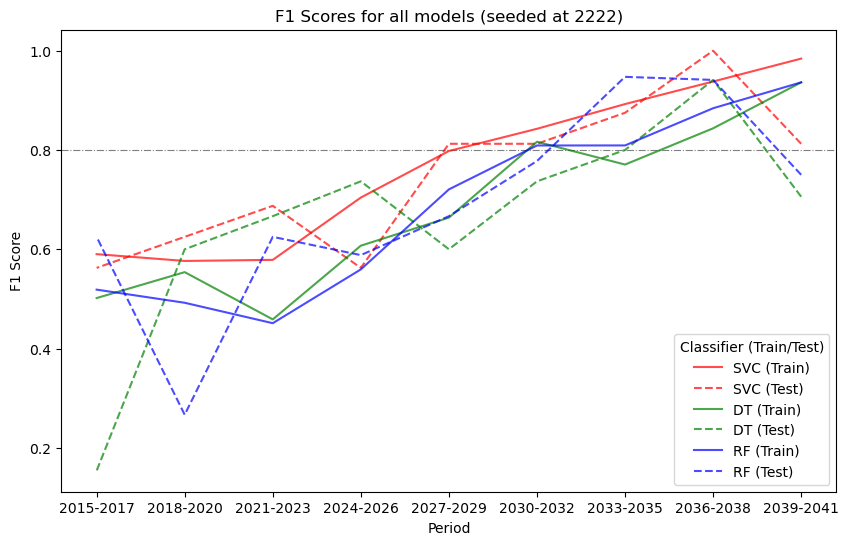

In [72]:
plt.figure(figsize=(10, 6))
plt.hlines = plt.axhline(y=0.8, color='gray', linestyle='-.', linewidth=.8)
# Flip the x-axis
plt.gca().invert_xaxis()
# Define colors for each model
colors = {'SVC': 'red', 'DT': 'green', 'RF': 'blue', 'ADA': 'orange'}
# Plot the F1 scores for each model
for model in f1_scores['classifier'].unique():
    model_scores = f1_scores[f1_scores['classifier'] == model]
    plt.plot(model_scores['Period'], model_scores['F1 score_train'], 
             label=f'{model} (Train)', 
             color=colors[model], alpha=0.7)
    plt.plot(model_scores['Period'], model_scores['F1 score_test'],
             '--', label=f'{model} (Test)', 
             color=colors[model], alpha=0.7)
# Set the x-axis label
plt.xlabel('Period')
# Set the y-axis label
plt.ylabel('F1 Score')
# Set the title
plt.title('F1 Scores for all models (seeded at 2222)')
# Add a legend
plt.legend(title='Classifier (Train/Test)')
# Show the plot
plt.show()